# DCNet - A simple LSTM-RNN for generating sequence consensus

- Explore building a LSTM for consensus sequence generation
- Train a model to learn the patterns in simulated noise sequences then use this model to generate the consensus sequence

# 1. Load libraries

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random

torch.manual_seed(42)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from matplotlib import pyplot as plt


# 2. Dataset

In [ ]:
len_seq = 220
seq = [random.choice(['A', 'C', 'G', 'T']) for _ in range(len_seq)]
print(''.join(seq))

GAGTACTTTAAGGCCATCCGTGGGCTTACATAACTATTTCTCTGAAGGGAGGAGGTGTTCGTAGAAGTATTGCCTTAGATCTTAAGTGGCCTTTTACTAAAAACGTTACGTGGGACCCTGCCCTAACAGAAGCACAACAGGTCAACGTCCTAGGTGATACAAGCAGCATACCTGAAGACGGCAGCCTCTAATCCGGGATGATTACGCATGGAACTAGCCG


### Convert the seq to a PyTorch tensor


In [ ]:
# utility functions for encoding DNA bases to vectors and simulate sequencing errors

def sim_error(seq, pi=0.05, pd=0.05, ps=0.01):
  '''
  Given an input sequence `seq`, generate another sequence w/ errors
  pi: insertion error rate
  pd: deletion error rate
  ps: substitution error rate
  '''

  out_seq = []
  for c in seq:
    while 1:
      r = random.uniform(0, 1)
      if r < pi:
        out_seq.append(random.choice(['A', 'C', 'G', 'T']))
      else:
        break
    
    r -= pi
    if r < pd:
      continue
    r -= pd
    if r < ps:
      out_seq.append(random.choice(['A', 'C', 'G', 'T']))
      continue
    out_seq.append(c)
  
  return ''.join(out_seq)

In [ ]:
bmap = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
def one_hot(b):
  t = [[0, 0, 0, 0]]
  i = bmap[b]
  t[0][i] = 1
  return t

print('one-hot encoding for DNA bases')
print('A:', one_hot('A'))
print('C:', one_hot('C'))
print('G:', one_hot('G'))
print('T:', one_hot('T'))

one-hot encoding for DNA bases
A: [[1, 0, 0, 0]]
C: [[0, 1, 0, 0]]
G: [[0, 0, 1, 0]]
T: [[0, 0, 0, 1]]


In [ ]:
seq_t = Variable(torch.FloatTensor([one_hot(c) for c in seq])).cuda()

Simulate 20 erroneous sequences w/ insertion error at 5%, deletion error at 5% and substitution error at 1%

In [ ]:
seqs = [sim_error(seq, pi=0.05, pd=0.05, ps=0.01) for _ in range(20)]
seqs_t = [Variable(torch.FloatTensor([one_hot(c) for c in s])).cuda() for s in seqs]
seqs

['AGTACTTAAAGCGCCATGCCCGTAGGGCCTTACATAACTATTTCTTGAAGGGAGGAGGTGTTCGTAGAAGTATTGGCCTTAGACCTTAATGGCCTTTTACTAAACGTTACGTCGGGACCTTGCCCGTGACACAGAAGCAACGGAGTCAACCCTAGGTGATACAAGCAGCATACCTGAAGACGGCAGCCCTCTAATCCGGGATTGTGTACACATGGAACTGCC',
 'GAGTACTTCAAGCCATCGTGGGCTTACATAACTATTTCTGAAGGGAGGAGGTGTTCGTAGAAGATATTGCCATTAGATTAAGGGCCTTTACTAAAACACGCTTACGTGGACCGCTGCCCTAACAGGAGCACAACAGGTCAAACGTCTGGTGAAACAAGCAGCATACCGAAGACGGCTAGCCTCTAATCCGGGATGATTACGCATGGAACAGGCCG',
 'GAGTACTTAAGGCCACTCCGTGGGCTTACATAAACTATTTCTCGAAGGGAGGAGGTGTGTCGTAGAAGTATTGCCTTAGATCTGTAAGTGGCCTTTTACTAAAAACGTTACGTGGACCCTGCCCTAAAGAAGACAACGGTCACGTCTAGGATACAAGCAGACATACTGAAGACTGCAGCCTCTAATCCGGATGATTACAGCATGGAACTAGCCG',
 'GAGCCTTTACATGAATCCGTGGGCTTAACATAACTATTTCTCTGAAGGCGGGAGGTGTTCAGTAGAAGTATGCTCACATTCTTAAGTGTCCTTTTACTAAACAGTTACGTGGGACCCTGCCCTAACAGAAGCACAAACAGGTCAACGTCCTAGGTGATACAGCAGCATACCTGAAGACGGCAGCCTCGTAGATCGGGATGTATTACGCTATGGAACTAGCCG',
 'GAGTCTTTAGGCAATCCGGGGTTACAAACTATGTTCTCTGAAGGGAGGAGGTTTCGTAGAAGTATTTGCTAGATTCTTAAGTGGCCTTTTACTAAAAACGTTACA

# 3. Model construction

In [ ]:
class DCNet(nn.Module):
  def __init__(self, hidden_dim, layer1_dim, layer2_dim):
    super(DCNet, self).__init__()
    self.hidden_dim = hidden_dim

    '''
    One LSTM layer that needs to specify the input dimension, hidden layer dimension,
    as well as the number of current layers.
    Here, use a 4-d one-hot encoding as the input
    '''
    self.lstm = nn.LSTM(input_size=4, hidden_size=hidden_dim, num_layers=1)

    # 2 fully-connected layers w/ ReLU as activation function
    self.linear1 = nn.Linear(in_features = hidden_dim, out_features=layer1_dim)
    self.relu1 = nn.ReLU()

    '''
    Add the 2nd fully-connected layer w/ ReLU as the activation function
    '''
    self.linear2 = nn.Linear(in_features=layer1_dim, out_features = layer2_dim)
    self.relu2 = nn.ReLU()

    # output layer
    '''
    Specify the output dimension
    Input: a vector of 4 dimension
    '''
    self.linear3 = nn.Linear(in_features=layer2_dim, out_features = 4)

    # Weight initialization
    self.hidden_init_values = None
    self.hidden = self.init_hidden()
    nn.init.xavier_uniform(self.linear1.weight)
    nn.init.xavier_uniform(self.linear2.weight)
    nn.init.xavier_uniform(self.linear3.weight)

  def init_hidden(self):
    if self.hidden_init_values == None:
      self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
                                 autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
    
    return self.hidden_init_values

  # Forward process
  def forward(self, seq):
    lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
    tmp1 = self.relu1(self.linear1(lstm_out.view(len(seq), -1)))
    tmp2 = self.relu2(self.linear2(tmp1))
    _out = self.linear3(tmp2)
    base_out = _out
    return base_out

Initialize the DCNet. You can use different parameters to initialize the model


In [ ]:
'''Initialize the neurons in hidden layers, such as 32 in LSTM layer, 12 neurons in each fully connected layers'''
dcnet = DCNet(hidden_dim = 50, layer1_dim = 20, layer2_dim = 40)

# Set the gradients manually to 0
dcnet.zero_grad()
dcnet.cuda()

# Initialize the parameters in the DCNet
dcnet.hidden = dcnet.init_hidden()

for name, param in dcnet.named_parameters():
  if 'bias' in name:
    nn.init.constant(param, 0.0)
  elif 'weight' in name:
    nn.init.xavier_normal(param)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  del sys.path[0]


# 4. Training the model: Loss and training operations

In [ ]:
# Use MSE as the loss function. You can use MAE too
loss_function = nn.MSELoss()

''' Initialise the learning rate as 0.1'''
lr = 0.1

# Use SGD to train the model
optimizer = optim.SGD(dcnet.parameters(), lr=lr)

The following loop train the DCNet using the noisy sequences. We also lower the leraning rate every 250 epochs

In [ ]:
range_ = (1, 200)
# Mini-batch: a subset of the training set that's used to evaluate the gradient of the loss function and update the weights
mini_batch_size = 5

# One epoch: an entire dataset is passed forward and backward through the NN exactly one time
n_epochs = 2000
for epoch in range(n_epochs):
  for i in range(int(len(seqs_t)/mini_batch_size)):
    loss = 0
    s, e = range_
    for seq2 in random.sample(seqs_t, mini_batch_size):
      dcnet.hidden = dcnet.init_hidden()
      dcnet.zero_grad()
      seq2 = seq2[s-1:e]
      seq_ = seq2.view(-1, 4)
      out = dcnet(seq_)
      loss += loss_function(out[:-1], seq_[1:])
    
    loss.backward()
    optimizer.step()
  
  if epoch % 250 == 0:
    print('epoch:', epoch, 'loss:', loss.cpu().data/mini_batch_size, 'learning rate:', lr)

    # Use a decreasing lr to converge to the optimal value
    decrease_rate = 0.95
    lr *= decrease_rate

    optimizer = optim.SGD(dcnet.parameters(), lr = lr)

epoch: 0 loss: tensor(0.1916, device='cpu') learning rate: 0.1
epoch: 250 loss: tensor(0.1762, device='cpu') learning rate: 0.095
epoch: 500 loss: tensor(0.1604, device='cpu') learning rate: 0.09025
epoch: 750 loss: tensor(0.1344, device='cpu') learning rate: 0.0857375
epoch: 1000 loss: tensor(0.0987, device='cpu') learning rate: 0.08145062499999998
epoch: 1250 loss: tensor(0.0782, device='cpu') learning rate: 0.07737809374999999
epoch: 1500 loss: tensor(0.0700, device='cpu') learning rate: 0.07350918906249998
epoch: 1750 loss: tensor(0.0653, device='cpu') learning rate: 0.06983372960937498


# 5. Results

In [ ]:
# Visualize the input and output tensors after we send the whole original template into the DCNet to reconstruct the output tensor
import numpy as np
dcnet.hidden = dcnet.init_hidden()
xout = dcnet(seq_t[:250])

x1 = xout[:-1].cpu().data.numpy()
xx1 = np.transpose(seq_t[1:250, 0, :].data.cpu().numpy())
xx2 = np.transpose(x1)

In [ ]:
dcnet.hidden = dcnet.init_hidden()
base_t = Variable(torch.FloatTensor([one_hot(seq[0])])).cuda()

consensus = []

for _ in range(201):
  xout = dcnet(base_t)
  next_t = [0, 0, 0, 0]
  next_t[np.argmax(xout.cpu().data.numpy())] = 1
  consensus.append(next_t)
  base_t = Variable(torch.FloatTensor([next_t])).cuda()

consensus = np.array(consensus)
consensus = consensus.transpose()

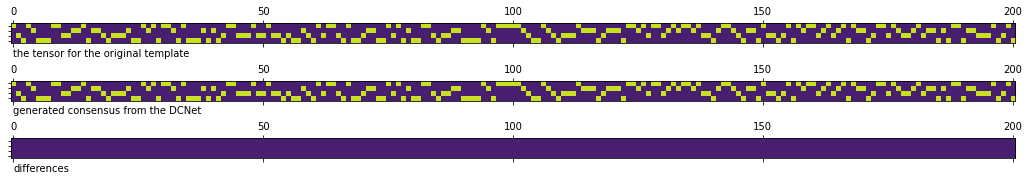

In [ ]:
plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(consensus, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"generated consensus from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(consensus-xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

In [ ]:
consensus-xx1[:, 0:201]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,